In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
folder = 'training_20180910/'


In [2]:
txts = [file for file in os.listdir(folder) if '.txt' in file]
anns = [file for file in os.listdir(folder) if '.ann' in file]
ids = [file.strip('.txt') for file in txts]

In [3]:
def load_txt(txt=None, i=None):
    '''
    Pass text file name or index to load file
    '''
    if txt is not None:
        with open(folder + txt) as f:
            lines = f.readlines()
        return lines
    elif i is not None:
        with open(folder + txts[i]) as f:
            lines = f.readlines()
        return lines
    
def load_txt(txt=None, i=None):
    '''
    Pass text file name or index to load file
    '''
    if txt is not None:
        with open(folder + txt) as f:
            lines = f.readlines()
        return lines
    elif i is not None:
        with open(folder + txts[i]) as f:
            lines = f.readlines()
        return lines


'''
Get chief complaint and history from medical record
Save to patient_record_summary.pickle
'''
patient_text_rows = []
            
for patient_id in ids:
    patient_text = {}
    
    txt = patient_id + '.txt'
    lines = load_txt(txt)
    
    # get chief complaint
    chief_complaint = ''
    chief_complaint_idx = -1
    chief_complaint_end_idx = -1
    
    # start and end of chief complaint
    for i, line in enumerate(lines):
        if 'chief complaint' in line.lower():
            chief_complaint_idx = i
            break
    for j, line in enumerate(lines[i:]):
        if line == '\n':
            chief_complaint_end_idx = j + i
            break
    
    # trim \n and join
    if chief_complaint_idx > -1:
        chief_complaint = lines[chief_complaint_idx:chief_complaint_end_idx]
        chief_complaint = [line.strip('\n') for line in chief_complaint]
        chief_complaint = ' '.join(chief_complaint)
        
    patient_text['chief_complaint'] = chief_complaint

    
    # get present history
    present_history = ''
    present_history_idx = -1
    present_history_end_idx = -1
    
    for i, line in enumerate(lines):
        if 'history of present illness' in line.lower():
            present_history_idx = i
            break
    for j, line in enumerate(lines[i+3:]):
        #find the next header
        if ':' in line:
            present_history_end_idx = j + i + 3
            break
    
    if present_history_idx > -1:
        present_history = lines[present_history_idx:present_history_end_idx]
        present_history = [line.strip('\n') for line in present_history]
        present_history = ' '.join(present_history)
    
    patient_text['present_history'] = present_history
    
    
    patient_text_rows.append(patient_text)
    
patient_df = pd.DataFrame(patient_text_rows, index=ids)
patient_df.to_csv('patient_record_summary.csv')

In [4]:
patient_df = pd.read_csv('patient_record_summary.csv')
patient_df = patient_df.fillna('')
lines = list(patient_df['chief_complaint'].str.lower() + ' \n ' + patient_df['present_history'].str.lower())

from sklearn import feature_extraction
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Perform Tf-Idf on present-history documents
vectorizer = feature_extraction.text.TfidfVectorizer()
# corpus = list(patient_df['present_history'])
vectors = vectorizer.fit_transform(lines)

# mat = cosine_similarity(vectors, vectors)

# modelkmeans = KMeans(3)
# modelkmeans.fit_transform(vectors)

# Attempt to find ideal number of clusters
# sum_of_squared_dists = []
# K = range(1, 150)
# for k in tqdm(K):
#     km = KMeans(n_clusters=k)
#     km = km.fit(vectors)
#     sum_of_squared_dists.append(km.inertia_)
# K = modelkmeans

# plt.plot(K[:len(sum_of_squared_dists)], sum_of_squared_dists)
# plt.scatter(K[13], sum_of_squared_dists[13])

In [5]:
kmeans = KMeans(3)
cluster_x = kmeans.fit_predict(vectors)
for i in range(3):
    print(np.sum(cluster_x == i))

85
110
108


In [7]:
from sklearn.decomposition import PCA
pca = PCA(6)
pca_x = pca.fit_transform(vectors.todense())

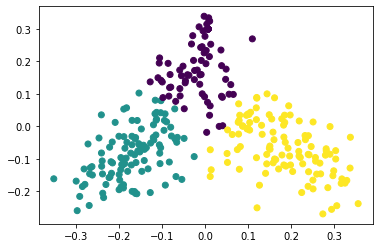

In [8]:
plt.scatter(pca_x.T[0], pca_x.T[1], c=cluster_x)

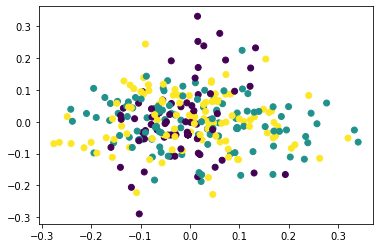

In [32]:
plt.scatter(pca_x.T[2], pca_x.T[5], c=cluster_x)

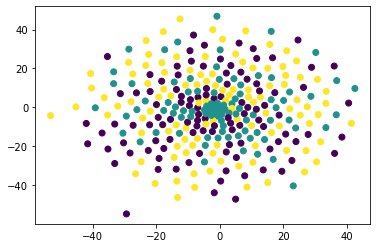

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(2, perplexity=5)
tsne_x = tsne.fit_transform(vectors.todense())

plt.scatter(tsne_x.T[0], tsne_x.T[1], c=cluster_x)

In [24]:
id_to_vocab = {}
for key in vectorizer.vocabulary_:
    id_to_vocab[vectorizer.vocabulary_[key]] = key

def print_pca_words(components, cutoff=0.09):
    '''
    Print out words that are most relevant to an axis
    of variation from PCA
    Pass in the components vector from PCA and cutoff of importance
    '''
    idxs = np.where(np.abs(components) > cutoff)[0]
    print([id_to_vocab[i] for i in idxs])
    

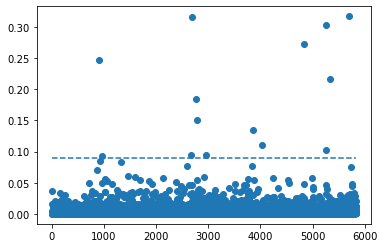

In [56]:
vocab_len = len(pca.components_[1])
plt.scatter(np.arange(vocab_len), np.abs(pca.components_[1]))
plt.plot([0, vocab_len], [0.09, 0.09], '--')

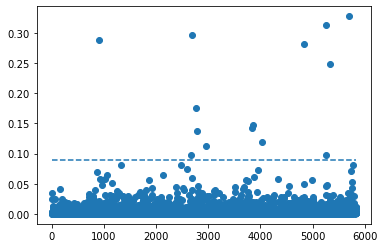

In [12]:
vocab_len = len(pca.components_[2])
plt.scatter(np.arange(vocab_len), np.abs(pca.components_[1]))
plt.plot([0, vocab_len], [0.09, 0.09], '--')

In [34]:
for i in range(5):
    print('Words important for the {}th pca component'.format(i))
    print_pca_words(pca.components_[i])

Words important for the 0th pca component
['he', 'her', 'his', 'she']
Words important for the 1th pca component
['and', 'had', 'he', 'her', 'his', 'in', 'of', 'on', 'patient', 'she', 'that', 'the', 'to', 'was']
Words important for the 2th pca component
['abdominal', 'and', 'chest', 'denies', 'has', 'he', 'no', 'on', 'or', 'pain', 'patient', 'reports', 'she', 'the', 'to', 'was']
Words important for the 3th pca component
['and', 'on', 'patient', 'pt', 'the', 'was']
Words important for the 4th pca component
['and', 'cath', 'chest', 'denies', 'he', 'her', 'his', 'of', 'pain', 'patient', 'pt', 'she', 'to', 'with']


In [44]:
print(pca.components_[2][chest_idx])
print(pca.components_[2][abdominal_idx])

0.10835587310695637
0.09251102602689903


In [4]:
def get_entities_relations(patient_id=None, i=None, lower=True):
    '''
    Read .ann file and convert to dataframe of entities and relations
    '''
    if patient_id is not None:
        ann = patient_id + '.ann'
    elif i is not None:
        ann = anns[i]
    lines = load_txt(ann)

    entities = []
    relations = []

    for line in lines:
        cols = line.strip('\n').strip('\t').split('\t')
        if len(cols) == 2:
            try:
                terms = cols[1].split(' ')
                label = terms[0]
                rel1 = terms[1]
                rel2 = terms[2]
                relations.append({
                    'id': cols[0],
                    'label': label,
                    'rel1': rel1,
                    'rel2': rel2
                })
            except:
                #skip rows that have unknown formatting
                pass

        else:
            try:
                terms = cols[1].split(' ')
                label = terms[0]
                start = terms[1]
                stop = terms[2]
                entities.append({
                    'id': cols[0],
                    'label': label,
                    'start': start,
                    'stop': stop,
                    'value': cols[2]
                })
            except:
                #skip rows that have unknown formatting
                pass


        idx = line.split('\t')[0]
        line = line.split('\t')

    entities = pd.DataFrame(entities).set_index('id')
    relations = pd.DataFrame(relations).set_index('id')

    if lower:
        entities['value'] = entities['value'].str.lower()
    return entities, relations



def get_reason_drug(entities, relations):
    '''Pull Reason, Drug from entities, Reason-Drug from relations'''
    reasons = list(entities[entities['label'] == 'Reason']['value'])
    drugs = list(entities[entities['label'] == 'Drug']['value'])
    reason_drug = relations[relations['label'] == 'Reason-Drug']
    
    return reasons, drugs, reason_drug
    
def get_reason_drug_pairs(entities, reason_drug):
    '''Get references from Reason-Drug relations and turn into
    tuples of reason and drug'''
    reason_drug_pairs = []
    for row in reason_drug.iterrows():
        id1 = row[1]['rel1'].split('Arg1:')[1]
        id2 = row[1]['rel2'].split('Arg2:')[1]


        reason = entities.loc[id1, 'value']
        drug = entities.loc[id2, 'value']

        reason_drug_pairs.append((reason, drug))
    return reason_drug_pairs


def convert_to_lines(reasons, drugs, reason_drug_pairs):
    '''
    Convert reasons and drugs into lines
    '''
    reasons = [(' <reas> ' + reason)
                   for reason in reasons]
    drugs = [(' <drug> ' + drug) 
                 for drug in drugs]
    pairs = [(' <pair> ' + reason + ' <sep> ' + drug) 
                 for reason, drug in reason_drug_pairs]
    # reasons = '<reas>' + ' '.join(np.unique(reasons))
    # drugs = '<drug>' + ' '.join(np.unique(drugs))
    # pairs = '<pair>' + '. '.join([reason + ', ' + drug for reason, drug in 
    #                        reason_drug_pairs])
    return reasons, drugs, pairs


# def mask_reason_drug_pairs(reason_drug_pairs):
# all_reason_drug_pairs = []
# for i in tqdm(range(len(anns))):
#     entities, relations = get_entities_relations(i=i)
#     reasons, drugs, reason_drug = get_reason_drug(entities, relations)
#     reason_drug_pairs = get_reason_drug_pairs(entities, reason_drug)
#     reasons, drugs, reason_drug_pairs = \
#         convert_to_lines(reasons, drugs, reason_drug_pairs)
    
#     all_reason_drug_pairs += reason_drug_pairs
    
    
    

In [5]:
# Go through all the .ann files to collect drug, reason and drug_reason pairs
# Build into a training database into memory
# Build into a list of all_reason_drug_pairs lines to train tokenizer
all_reason_drug_pairs = []
training_lines = []
for i in tqdm(range(len(anns))):
    entities, relations = get_entities_relations(i=i)
    reasons, drugs, reason_drug = get_reason_drug(entities, relations)
    reason_drug_pairs = get_reason_drug_pairs(entities, reason_drug)
    reasons, drugs, reason_drug_pairs = \
        convert_to_lines(reasons, drugs, reason_drug_pairs)
    
    # used to build vocab
    all_reason_drug_pairs += reason_drug_pairs
    
    # used to train on
    line = ''.join(reasons) + ' ' + ''.join(drugs) + ' ' + ''.join(reason_drug_pairs) + '</s>'
    training_lines.append(line)

    
# Convert lines with reasons, drugs, and reason-drug pairs to training_lines
file =  open('ann_train.txt', 'w')
for line in training_lines:
    file.write(line + '\n')
file.close()


100%|███████████████████████████████████████████████████████████████████████████████| 303/303 [00:02<00:00, 115.60it/s]


In [85]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
import torch

# Go through all the .ann files to collect drug, reason and drug_reason pairs
# Build into a training database into memory
# Build into a list of all_reason_drug_pairs lines to train tokenizer
all_reason_drug_pairs = []
training_lines = []
for i in tqdm(range(len(anns))):
    entities, relations = get_entities_relations(i=i)
    reasons, drugs, reason_drug = get_reason_drug(entities, relations)
    reason_drug_pairs = get_reason_drug_pairs(entities, reason_drug)
    reasons, drugs, reason_drug_pairs = \
        convert_to_lines(reasons, drugs, reason_drug_pairs)
    
    # used to build vocab
    all_reason_drug_pairs += reason_drug_pairs
    
    # used to train on
    line = ''.join(reasons) + ' ' + ''.join(drugs) + ' ' + ''.join(reason_drug_pairs) + '</s>'
    training_lines.append(line)

    
# Convert lines with reasons, drugs, and reason-drug pairs to training_lines
file =  open('ann_train.txt', 'w')
for line in training_lines:
    file.write(line + '\n')
file.close()


    
    
tokenizer = Tokenizer(WordLevel(unk_token='<unk>'))

trainer = WordLevelTrainer(special_tokens=['<unk>', '<reas>', '<drug>', '<pair>',
                                           '<sep>', '<mask>', '<s>', '</s>'])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.train_from_iterator(all_reason_drug_pairs, trainer=trainer)

tokenizer.enable_truncation(max_length=512) 
tokenizer.mask_token_id = 5
#only 18 cases that end up larger than 512



#generate dataset from memory
train_dataset = [{'input_ids': tokenizer.encode(line).ids} for line in training_lines]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#generate data_collator
def mlm_collator(dataset_iterator, padding=512):
    MASK_TOKEN = 5
    PAIR_TOKEN = 3
    
    # lines = training_lines[starting_idx:starting_idx+batch_size]
    tensor_lines = []
    attention_masks = []
    all_labels = []
    # masking
    for data in dataset_iterator:
        tensor_line = torch.zeros(padding)
        attention_mask = torch.ones(padding)
        labels = torch.full((padding,), -100.0)
        masks_padded = torch.zeros(padding)
        
        # Mask 15% of elements from the reason-drug pair
        # section which are not special tokens
        line = torch.tensor(data['input_ids'])
        tensor_line[:len(line)] = line

        pair_mask = torch.zeros(len(line))
        pair_start = torch.argmax((line == PAIR_TOKEN)*1)
        pair_mask[pair_start+1:] = 1
        
        mask_arr = ((torch.rand(len(line)) < 0.15)*1) * ((line > 7)*1)
        
        masks = pair_mask * mask_arr
        masks_padded[:len(line)] = masks[:len(line)]
        
        labels[masks_padded == 1] = tensor_line[masks_padded == 1]
        
        tensor_line[masks_padded == 1] = MASK_TOKEN
        
        tensor_lines.append(tensor_line)
        
        attention_mask[len(line):] = 0
        attention_masks.append(attention_mask)
        
        all_labels.append(labels)
        
        
        
    return {
        'input_ids': torch.vstack(tensor_lines).to(torch.int64).to(device), 
        'attention_mask': torch.vstack(attention_masks).to(torch.int64).to(device), 
        'labels': torch.vstack(all_labels).float().to(torch.int64).to(device)
    }

# data = mlm_collator(dataset)

100%|███████████████████████████████████████████████████████████████████████████████| 303/303 [00:02<00:00, 132.46it/s]


In [129]:
from transformers import RobertaTokenizerFast
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM

# tokenizer2 = RobertaTokenizerFast.from_pretrained("tokenizer", max_len=512)
# tokenizer.add_special_tokens({'additional_special_tokens': ['<pair>', '<drug>', '<reas>']})

config = RobertaConfig(
    # vocab_size=tokenizer.get_vocab_size(),
    vocab_size=len(tokenizer.vocab),
    max_position_embeddings=514,
    num_attention_heads=4,
    num_hidden_layers=2,
    type_vocab_size=1,
)

model = RobertaForMaskedLM(config=config)

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./model",
    overwrite_output_dir=True,
    num_train_epochs=20,
    per_gpu_train_batch_size=16,
    save_steps=50,
    save_total_limit=2,
    prediction_loss_only=True,
    report_to=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    # data_collator=mlm_collator,
    # train_dataset=train_dataset,
    data_collator=data_collator,
    train_dataset=dataset,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [130]:
trainer.train()

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
***** Running training *****
  Num examples = 303
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 380
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [363]:
%%time
trainer.train()

C:\Users\Andy\miniconda3\lib\site-packages\transformers\optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 303
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 40


AttributeError: 'list' object has no attribute 'mask_token'

# BERT model

In [1]:


from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer = tokenizer.train_new_from_iterator(all_reason_drug_pairs, vocab_size=2446)

# tokenizer = AutoTokenizer.from_pretrained('ann/tokenizer')
tokenizer.add_special_tokens({'additional_special_tokens': 
                             ['<pair>', '<drug>', '<reas>', '<sep>']})


from transformers import BertConfig
from transformers import BertForMaskedLM

config = BertConfig(
    vocab_size=len(tokenizer.vocab),
    max_position_embeddings=514,
    num_attention_heads=4,
    num_hidden_layers=2,
)
model = BertForMaskedLM(config=config)



from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="ann_train.txt",
    block_size=512
)

from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./reason_drug_model",
    overwrite_output_dir=True,
    num_train_epochs=20,
    per_gpu_train_batch_size=16,
    save_steps=50,
    save_total_limit=2,
    prediction_loss_only=True,
    report_to=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

trainer.train()
trainer.save_model('model')

C:\Users\Andy\miniconda3\lib\site-packages\transformers\data\datasets\language_modeling.py:125: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


In [2]:
from transformers import pipeline

fill_mask = pipeline(
    'fill-mask',
    model='model',
    tokenizer='tokenizer'
)

404 Client Error: Repository Not Found for url: https://huggingface.co/model/resolve/main/config.json


OSError: model is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

In [75]:
fill_mask('<pair> antispasmodic effect <sep> [MASK]')

[{'score': 0.017089417204260826,
  'token': 122,
  'token_str': 'pain',
  'sequence': 'antispasmodic effect pain'},
 {'score': 0.013402320444583893,
  'token': 62,
  'token_str': '##p',
  'sequence': 'antispasmodic effectp'},
 {'score': 0.013084339909255505,
  'token': 15,
  'token_str': '-',
  'sequence': 'antispasmodic effect -'},
 {'score': 0.010758491232991219,
  'token': 101,
  'token_str': '##in',
  'sequence': 'antispasmodic effectin'},
 {'score': 0.00795066449791193,
  'token': 209,
  'token_str': 'constipation',
  'sequence': 'antispasmodic effect constipation'}]

In [93]:
fill_mask(' <drug> lisinopril <drug> pravastatin <drug> aspirin <drug> narcotics <drug> tylenol <drug> lidoderm <drug> fentanyl <drug> morphine <drug> haldol <drug> klonopin <drug> fentanyl <drug> oxygen <drug> narcotic <drug> o2 <drug> o2  <pair> chest pain <sep> nitroglycerin <pair> anxiety <sep> lorazepam <pair> constipation <sep> lactulose <pair> constipation <sep> polyethylene glycol <pair> constipation <sep> senna <pair> sob <sep> albuterol sulfate <pair> wheeze <sep> albuterol sulfate <pair> sob <sep> albuterol sulfate <pair> sob <sep> ipratropium bromide <pair> wheeze <sep> ipratropium bromide <pair> pain <sep> oxycodone-acetaminophen <pair> chest pain <sep> nitroglycerin <pair> anxiety <sep> lorazepam <pair> constipation <sep> lactulose <pair> constipation <sep> polyethylene glycol 3350 <pair> anxiety <sep> ativan <pair> anxiety <sep> percocet <pair> constipation <sep> senna <pair> low back pain <sep> ativan <pair> low back pain <sep> percocet <pair> dyspnea <sep> albuterol sulfate <pair> sob <sep> ipratropium [MASK] <pair> back pain <sep> lidocaine <pair> anxiety <sep> lorazepam')

[{'score': 0.013711533509194851,
  'token': 15,
  'token_str': '-',
  'sequence': 'lisinopril pravastatin aspirin narcotics tylenol lidoderm fentanyl morphine haldol klonopin fentanyl oxygen narcotic o2 o2 chest pain nitroglycerin anxiety lorazepam constipation lactulose constipation polyethylene glycol constipation senna sob albuterol sulfate wheeze albuterol sulfate sob albuterol sulfate sob ipratropium bromide wheeze ipratropium bromide pain oxycodone - acetaminophen chest pain nitroglycerin anxiety lorazepam constipation lactulose constipation polyethylene glycol 3350 anxiety ativan anxiety percocet constipation senna low back pain ativan low back pain percocet dyspnea albuterol sulfate sob ipratropium - back pain lidocaine anxiety lorazepam'},
 {'score': 0.010350138880312443,
  'token': 101,
  'token_str': '##in',
  'sequence': 'lisinopril pravastatin aspirin narcotics tylenol lidoderm fentanyl morphine haldol klonopin fentanyl oxygen narcotic o2 o2 chest pain nitroglycerin anxiet

In [78]:
from transformers import pipeline

fill_mask2 = pipeline(
    'fill-mask',
    model='model2',
    tokenizer='tokenizer'
)

loading configuration file model2\config.json
Model config BertConfig {
  "_name_or_path": "model2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 2450
}

loading configuration file model2\config.json
Model config BertConfig {
  "_name_or_path": "model2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range

In [35]:
model.forward(default_data_collator(dataset[:2]))

AttributeError: 'dict' object has no attribute 'size'

In [3]:
import torch

In [16]:
from transformers import AutoModel
device = torch.device('cpu')
model = AutoModel.from_pretrained('ann/model')
def padding_collator(dataset, padding=128):
    inps = []
    for data in dataset:
        padded = torch.zeros(padding)
        inp = data['input_ids']
        inp = torch.tensor(inp)
        
        if len(inp) > len(padded):
            padded[:padding] = inp[:padding]
        else:
            padded[:len(inp)] = inp[:]
        inps.append(padded)
    inps = torch.vstack(inps).to(device).to(torch.int64)
    return inps

loading configuration file ann/model\config.json
Model config BertConfig {
  "_name_or_path": "ann/model",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 2450
}

loading weights file ann/model\pytorch_model.bin
Some weights of the model checkpoint at ann/model were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.

In [17]:
inps = padding_collator(dataset[:4])

C:\Users\Andy\miniconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [22]:
tokenizer.decode(inps[0])

'[CLS] <reas> recurrent seizures <reas> agitation <reas> agitation <reas> asthma <reas> wheezing <reas> ventilator associated pneumonia <reas> asthma <reas> diuresed <reas> elevated cr 1. 9 <reas> low bps <reas> hypertension <reas> pain <reas> pain <reas> cap <reas> asthma <reas> constipation <reas> constipation <reas> pain <reas> fever <reas> sleep <reas> pain <reas> fever <reas> sob <reas> back pain <reas> seizure <reas> longer than 5 minutes <reas> seizures <reas> grand mal seizure <reas> aggitated <drug> ativan <drug> topiramate <drug> vancomycin <drug> cefepime <drug> flagyl <drug> cipro <drug> oseltamavir <drug> soludemedrol <drug> albuterol <drug> sedation <drug> seroquel <drug> vecuronium <drug> albuterol <drug> ipratriopium <drug> prednisone'

In [18]:
inps

tensor([[   2, 2448, 1002,  547, 2448,  466, 2448,  466, 2448,  675, 2448,  371,
         2448, 1153,  820,  186, 2448,  675, 2448,  816, 2448, 1154, 1067,   19,
           16,   27, 2448,  457,  658,   76, 2448,  404, 2448,  122, 2448,  122,
         2448,  698, 2448,  675, 2448,  209, 2448,  209, 2448,  122, 2448,  298,
         2448, 1207, 2448,  122, 2448,  298, 2448,  699, 2448,  486,  122, 2448,
          300, 2448, 2009,  104,  318,  113,   23, 2011,  266,  142, 2448,  547,
         2448,  679, 1248,  928,  300, 2448, 1899, 1188, 2447,  386, 2447,  265,
          227,  127,  161, 2447,  213, 2447,  384, 2447,  338, 2447,  501, 2447,
           48, 1448,   60,   72,  127, 2099, 2447, 1782,  743,   77, 1084, 2447,
          225, 2447,  882, 2447, 1292, 2447,   55,  155,  208,  102,  234, 2447,
          225, 2447,  584,   78, 2289,  234, 2447,  372],
        [   2, 2448,  200,   76,   62, 1187,  132,  129, 1069, 1341, 2448, 2158,
          821, 2448, 1515, 2448, 1515, 2448,  617, 

In [19]:
model.to(device)
model.eval()
outputs = model.forward(inps)

In [20]:
outputs['last_hidden_state'].shape

torch.Size([4, 128, 768])

In [101]:
inp = torch.vstack([data['input_ids'] for data in dataset[:]]).to(device)

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 512 but got size 448 for tensor number 3 in the list.